# Propriétés thermiques du $Ca_2BrN$

Quentin Bodart - 70362100

## Imports

In [10]:
from mp_api.client import MPRester
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

mp_key = "cLLBrCi8gU7SqhnPKS4NJqSKB4Y6d0gD"
mp_id = "mp-23009"

with MPRester(mp_key) as m:
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    struct = m.get_structure_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Constantes

In [11]:
h = 6.62607015e-34
hbar = 1.05457182e-34
k_B = 1.380649e-23
R = 8.314
N_at = len(struct)
t = [i for i in range(1,1001)]
real_cv = [ph_dos.cv(ct)/(3*N_at*R) for ct in t]

## Modèles de Debye et d'Einstein

### Modèle d'Einstein

La température de Einstein (T_E) est donnée par $\theta_E = \hbar \omega_E/k_B$  
avec $\omega_E$ l'unique fréquence du modèle d'Einstein.


La chaleur spécifique d'Einstein adimensionelle (CV_E) est donnée par 
$$
\text{CV_E} = \frac{C_v}{3 N_{at}R} = \left( \frac{\theta_E}{T} \right)^2 \frac{e^{\theta_E}/T}{(e^{\theta_E/T} -1)^2}
$$

In [12]:
CV_E = lambda T,T_E: (T_E/T)**2 * np.exp(T_E / T)/(np.exp(T_E / T) - 1) ** 2

# Fitting the curve
theta_E = curve_fit(CV_E, t, real_cv, p0=200)[0][0]
omega_E = k_B*theta_E/hbar
f_E = 1e-12*omega_E/(2*np.pi) #THz
print(f"Einstein frequency : {f_E} [THz]\nFitted Einstein temperature using Sum of Squares Error : {theta_E})°K")

Einstein frequency : 6.088367360528921 [THz]
Fitted Einstein temperature using Sum of Squares Error : 292.19554948346547)°K


### Modèle de Debye

La température de Debye (T_D) est donnée par $\theta_D = \hbar \omega_D/k_B$


La chaleur spécifique de Debye adimensionelle (CV_D) est donnée par 
$$
\text{CV_D} = \frac{C_v}{3 N_{at}R} = 3 \left(\frac{T}{\theta_D}\right)^3 \int^{\theta_D/T}_{0} \frac{x^4e^x}{(e^x-1)^2}dx
$$

L'intégrande pouvant devenir trop grand pour être stocké dans python (overflow), on le réécrit:
$$
\frac{x^4e^x}{(e^x-1)^2} = \frac{e^x}{e^{2x}}\frac{x^4}{(1-e^{-x})^2} = \frac{x^4e^{-x}}{(1-e^{-x})^2}
$$

In [13]:
function = lambda x : x**4*np.exp(-x)/(1-np.exp(-x))**2

def CV_D(T,T_D):
    """
    Since the `quad` function is not broadcastable, calculates all values one by one
    """
    if type(T) == int: T = [T]
    return [3*((cT/T_D)**3)*quad(function, 1e-15, T_D/cT)[0] for cT in T]

# Fitting the curve
theta_D = curve_fit(CV_D, t, real_cv, p0=400)[0][0]
omega_D = k_B*theta_D/hbar
f_D = 1e-12*omega_D/(2*np.pi) #THz
print(f"Debye frequency : {f_D} [THz]\nFitted Debye temperature using Sum of Squares Error : {theta_D}°K")

Debye frequency : 8.255582918951463 [THz]
Fitted Debye temperature using Sum of Squares Error : 396.20549228812837°K


## Représentation graphique des capacités calorifiques

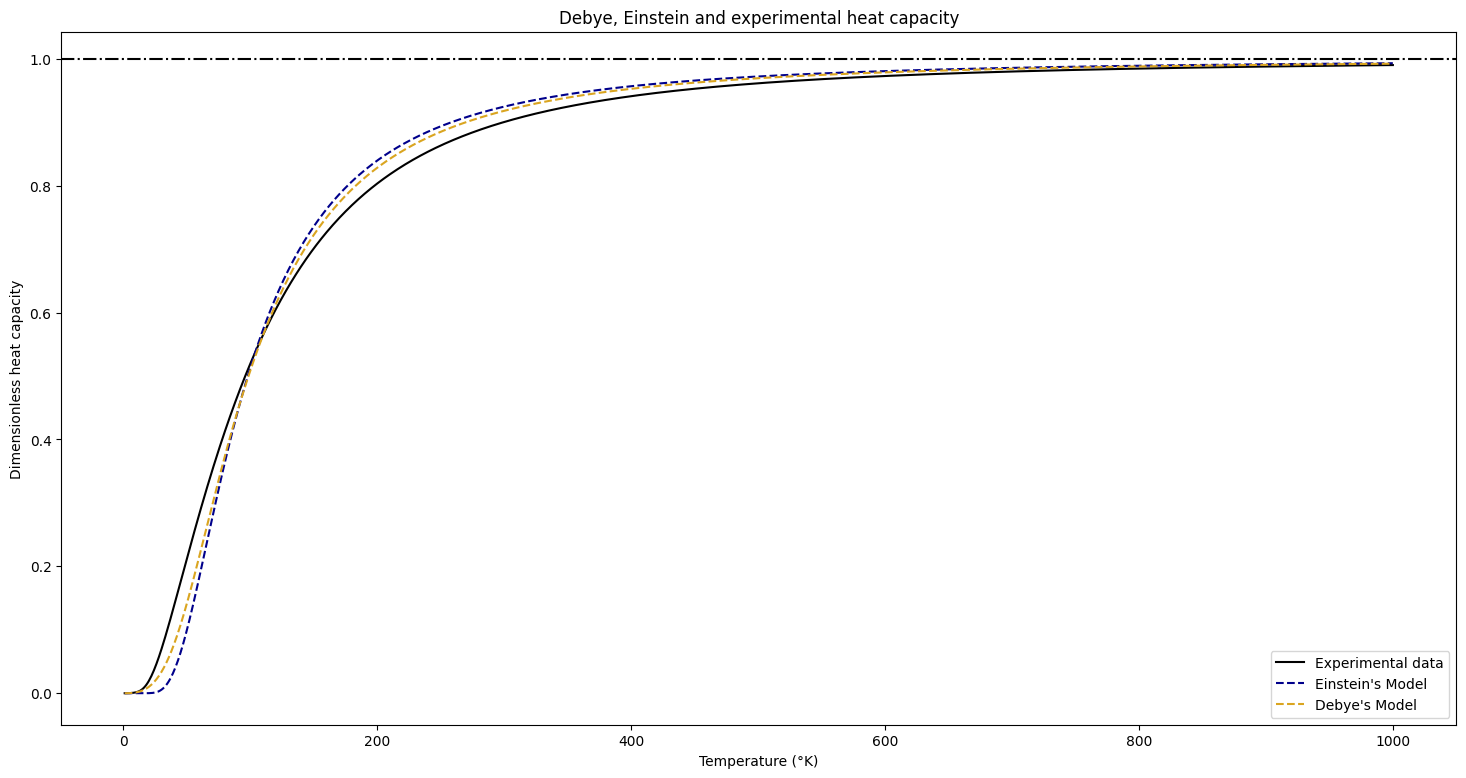

In [14]:
plt.rcParams["figure.figsize"] = (18,9) # Set size for all plots
plt.plot(t,real_cv, label='Experimental data',color='black')
plt.plot(t,[CV_E(ct,theta_E) for ct in t],linestyle='dashed', label='Einstein\'s Model', color='darkblue')
plt.plot(t,[CV_D(ct,theta_D) for ct in t],linestyle='dashed', label='Debye\'s Model', color='goldenrod')
plt.axhline(1, linestyle='-.',color='black')
plt.xlabel("Temperature (°K)")
plt.ylabel("Dimensionless heat capacity")
plt.legend()
plt.title("Debye, Einstein and experimental heat capacity")
plt.show()

On peut voir que le modèle de Debye se rapproche plus des données expérimentales que celui d'Einstein, et est par conséquent plus proche de la réalité.

## Densité de modes

Dans le modèle d'Einstein, $g_E(w)$ est un delta de dirac situé à la fréquence $\omega_E$.

Dans le modèle de Debye, $g_D(w)$ vaut $\large \frac{3 N_{at}\Omega \omega^2}{2 \pi^2 v^3}$ si $\omega \lt \omega_D$ et $0$ ailleurs, où $\large v = \frac{\omega_D}{q_D} = \frac{\omega_D}{\left(\frac{6\pi^2}{\Omega}\right)^{1/3}}$

En simplifiant, on obtient
$$
g_D(w)_{\omega \lt \omega_D} = 9 N_{at}\frac{\omega^2}{\omega_D^3}
$$


Experimental data area : 11.999952108304583
Einstein model area : 12
Debye model area : 11.961994772862358


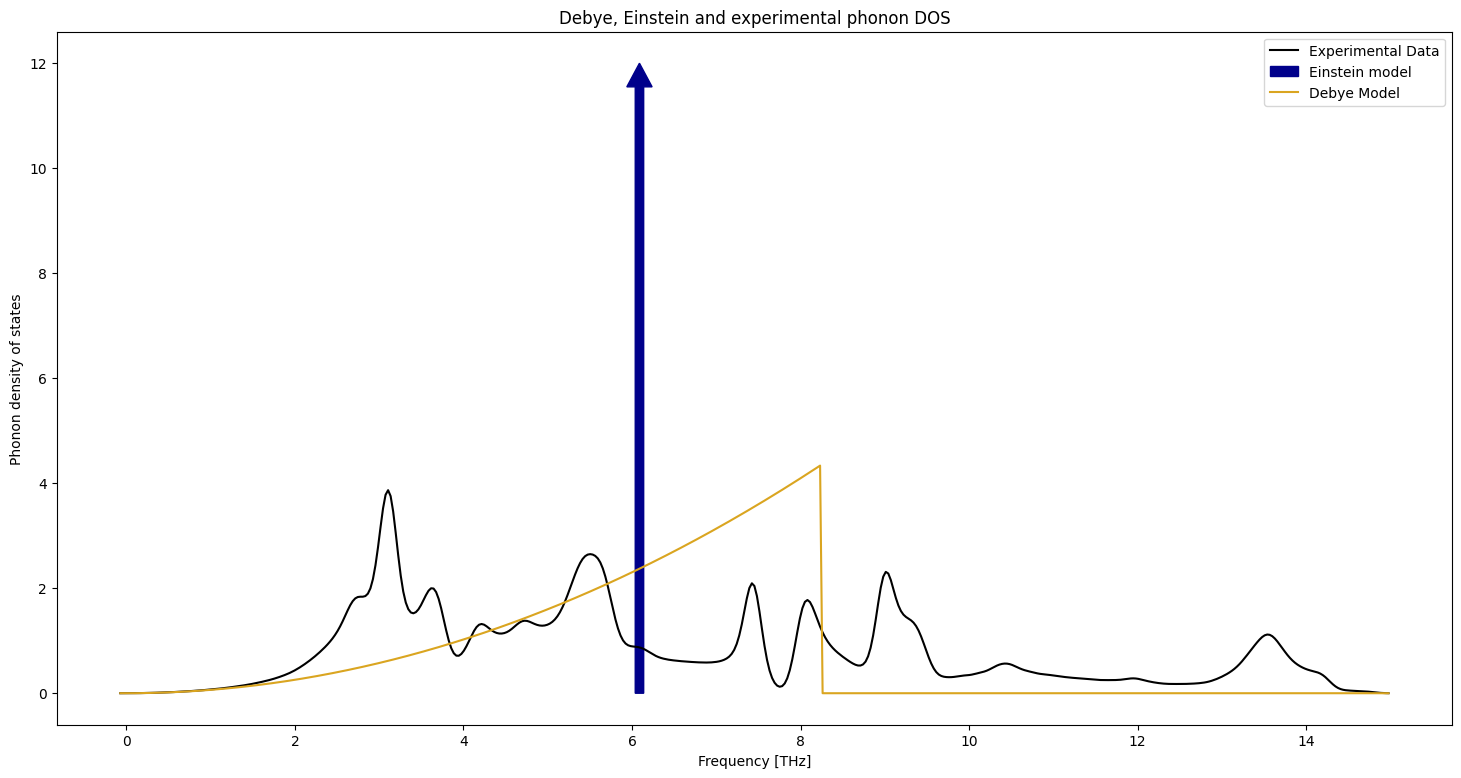

In [15]:
f = [cf for cf in ph_dos.frequencies if cf<=15]
d = ph_dos.densities[:len(f)] # Everything is null after 15

# model DOS
g_E = 3*N_at
g_D = [9*N_at*(cf**2)/f_D**3 if cf<f_D else 0 for cf in f]

# Plots
arrow = plt.arrow(f_E,0,0,g_E,length_includes_head=True, width=.1, color='darkblue') # Einstein
exp_plot, = plt.plot(f,d,label="experimental data", color='black')
debye_plot, = plt.plot(f,g_D,color='goldenrod') # Debye

plt.xlabel("Frequency [THz]")
plt.ylabel("Phonon density of states")
plt.legend([exp_plot,arrow,debye_plot,], ['Experimental Data','Einstein model','Debye Model',])
plt.title("Debye, Einstein and experimental phonon DOS")

# Riemman sum to check areas
A_debye = sum([g_D[i]*(f[i+1]-f[i]) for i in range(len(f)-1)])
A_exp = sum([d[i]*(f[i+1]-f[i]) for i in range(len(f)-1)])
print(f"Experimental data area : {A_exp}")
print(f"Einstein model area : {g_E}")
print(f"Debye model area : {A_debye}")